# CBOW text classification

# NSMC 데이터 확인

- NSMC 데이터란? 
  - Naver sentiment movie corpus v1.0
  - 네이버 영화 댓글 감성 분석 데이터셋
  - 이진 분류 문제 0 or 1, positive or negative
- https://github.com/e9t/nsmc

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/nlp"

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(f"{base_path}/data/nsmc/ratings_train.txt", sep='\t')

In [5]:
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
# pos, neg 비율
df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

## Missing 데이터 확인

In [7]:
sum(df['document'].isnull())

5

In [8]:
# 공백 제거
df = df[~df['document'].isnull()]

In [9]:
sum(df['document'].isnull())

0

In [10]:
df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## Tokenization

자연어를 모델이 이해하기 위해서는 자연어를 숫자 형식으로 변환시켜야한다.

In [11]:
# 첫번째 데이터 띄어ㅆ쓰기 기준으로 나누기

df['document'].iloc[0].split()

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [12]:
vocab = set()
for doc in df['document']:
  for token in doc.split():
    vocab.add(token)

In [13]:
# 너무 큰 테이블
len(vocab)

357862

In [14]:
# tokenization - 몇번 나오는지 체크
vocab_cnt_dict = {}
for doc in df['document']:
  for token in doc.split():
    if token not in vocab_cnt_dict:
      vocab_cnt_dict[token] = 0
    vocab_cnt_dict[token]+=1

In [15]:
# 리스트화
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [16]:
vocab_cnt_list[:10]

[('아', 1204),
 ('더빙..', 2),
 ('진짜', 5929),
 ('짜증나네요', 10),
 ('목소리', 99),
 ('흠...포스터보고', 1),
 ('초딩영화줄....오버연기조차', 1),
 ('가볍지', 17),
 ('않구나', 2),
 ('너무재밓었다그래서보는것을추천한다', 1)]

In [17]:
# 내림차순
top_vocabs = sorted(vocab_cnt_list, key = lambda tup:tup[1], reverse = True)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
cnts = [cnt for _, cnt in top_vocabs]

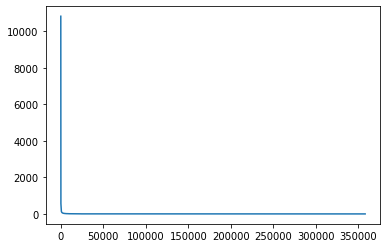

In [20]:
plt.plot(range(len(cnts)),cnts)

In [21]:
np.mean(cnts)

3.1792590439890236

In [22]:
cnts[:10]

[10825, 8239, 7791, 5929, 5059, 3598, 3285, 3260, 3249, 3237]

In [24]:
# 3번 이상 쓰인 vocab 수
sum(np.array(cnts)>2)

42635

In [25]:
n_vocab = sum(np.array(cnts)>2)

In [26]:
top_vocabs[:5]

[('영화', 10825), ('너무', 8239), ('정말', 7791), ('진짜', 5929), ('이', 5059)]

In [27]:
top_vocabs_truncated = top_vocabs[:n_vocab]

In [29]:
vocabs = [token for token, _ in top_vocabs_truncated]

In [30]:
vocabs[:5]

['영화', '너무', '정말', '진짜', '이']

## PAD token UNK token!

- UNK token은 Unknown token 의미
- PAD token은 Padding을 위한 token 의미

In [34]:
unk_token = '[UNK]'
unk_token in vocabs

True

In [35]:
pad_token = '[PAD]'
pad_token in vocabs

False

In [33]:
vocabs.insert(0, unk_token)

In [36]:
vocabs.insert(0, pad_token)

In [38]:
vocabs[:5]

['[PAD]', '[UNK]', '영화', '너무', '정말', '진짜', '이', '영화.', '왜', '더']

In [39]:
idx_to_token = vocabs
token_to_idx = {token : i for i, token in enumerate(idx_to_token)}

In [42]:
class Tokenizer:
  def __init__(self, vocabs, use_padding=True, max_padding=64, pad_token='[PAD]', unk_token='[UNK]'):
    self.idx_to_token = vocabs
    self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
    
    self.use_padding = use_padding
    self.max_padding = max_padding

    self.pad_token = pad_token
    self.unk_token = unk_token

    self.unk_token_idx = self.token_to_idx[self.unk_token]
    self.pad_token_idx = self.token_to_idx[self.pad_token]

  def __call__(self, x):
    token_ids = []

    token_list = x.split() # 띄어쓰기 단위로 나뉨

    for token in token_list:
      if token in self.token_to_idx:
        token_idx = self.token_to_idx[token]
      else:
        token_idx = self.unk_token_idx
      token_ids.append(token_idx)

    if self.use_padding:
      token_ids = token_ids[:self.max_padding]
      n_pads = self.max_padding - len(token_ids)
      token_ids = token_ids + [self.pad_token_idx] * n_pads

    return token_ids

In [43]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [44]:
sample = df['document'].iloc[0]
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [45]:
tokenizer(sample)

[51, 1, 5, 10485, 1064]

In [46]:
token_length_list = []
for sample in df['document']:
  token_length_list.append(len(tokenizer(sample)))

Text(0, 0.5, 'count')

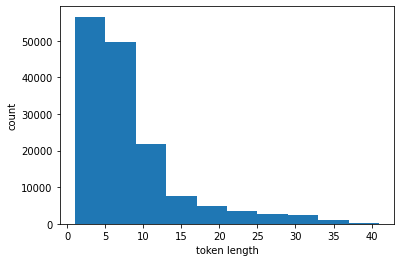

In [47]:
plt.hist(token_length_list)
plt.xlabel("token length")
plt.ylabel("count")

In [48]:
max(token_length_list)

41

In [50]:
tokenizer = Tokenizer(vocabs, use_padding=True, max_padding=50, pad_token='[PAD]', unk_token='[UNK]')

In [51]:
tokenizer(sample)

[201,
 2,
 3635,
 1,
 121,
 1946,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## DataLoader

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

In [54]:
train_valid_df = pd.read_csv(f"{base_path}/data/nsmc/ratings_train.txt", sep = '\t')
test_df = pd.read_csv(f"{base_path}/data/nsmc/ratings_test.txt", sep = '\t')

In [56]:
print(len(train_valid_df))
print(len(test_df))

150000
50000


In [59]:
# shuffle 해주기
train_valid_df = train_valid_df.sample(frac=1.)

In [60]:
train_ratio = 0.8

n_train = int(len(train_valid_df) * train_ratio)

train_df = train_valid_df[:n_train]
valid_df = train_valid_df[n_train:]

In [61]:
print(len(train_df))
print(len(valid_df))

120000
30000


In [62]:
#  1/10로 샘플링

train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
test_df = test_df.sample(frac=0.1)

In [ ]:
class NSMCDataset(Dataset):
  